# Long Short-Term Memory

In this jupyter notebook you will find the implementation of the long short-term memory algorithm using the sklearn library. It will help to test this algorithm and to complete [forecasting.md](https://github.com/Hurence/historian/blob/forecasting/docs/forecasting.md) document.

First we need to import all the different libraries that we will use and we make the 'create_dataset' function, it will be used later. 

In [1]:
import time
import math
import numpy as np
import sklearn.linear_model as sk
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)

#### 1) Dataset

We prepare the dataset for the next step.

In [3]:
# Load the dataset
# ts_data = pd.read_csv('../data/dataHistorian.csv', sep=';', encoding='cp1252')
ts_data = pd.read_csv('../data/it-data-4metrics.csv', sep=',')

# Delete the useless columns
ts_data = ts_data.iloc[:,0:4]
ts_data.head()

,metric_id,timestamp,value,metric_name
0,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157723,13.375,cpu_prct_used
1,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157423,13.500,cpu_prct_used
2,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157123,13.375,cpu_prct_used
3,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156823,13.500,cpu_prct_used
4,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156523,13.750,cpu_prct_used


We create to dictionnary to class all the time series according to their metric_name and their metric_id.

In [4]:
# Creation of the dictionnary of all the metric_name in association with their metric_id
dic_name = {}
dic_id = {}
for indx in ts_data.index:
    if ts_data['metric_name'][indx] not in dic_name.keys():
        dic_name[ts_data['metric_name'][indx]] = []
    if ts_data['metric_id'][indx] not in dic_name[ts_data['metric_name'][indx]]:
        dic_name[ts_data['metric_name'][indx]].append(ts_data['metric_id'][indx])
        dic_id[ts_data['metric_id'][indx]] = [ts_data['metric_name'][indx]]
keys_name = list(dic_name.keys())
keys_id = list(dic_id.keys())

#### 2) Training the neural network

We are going to separate the series into a training and a testing serie (for each metric_id). Then this series are going to fit the neural network and to test it. We will store the results in dic_id for keep them and reuse them later.

In [5]:
sample = len(keys_id)
look_back = 10
supr=[]
for i in range(sample):
    indx = keys_id[i]
    indexNames = ts_data[ ts_data['metric_id'] == indx ].index
    data = ts_data.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,'value']
    dataset = data.values
    dataset = dataset.astype('float32')
    dic_id[indx].append(dataset)
    
    if len(dataset) > look_back*4: 
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset.reshape(-1, 1))

        # split into train and test sets
        train_size = int(len(dataset) * 0.67)
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

        # reshape into X=t and Y=t+1
        x_train, y_train = create_dataset(train, look_back)
        x_valid, y_valid = create_dataset(test, look_back)

        # reshape input to be [samples, time steps, features]
        x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
        x_valid = np.reshape(x_valid, (x_valid.shape[0], 1, x_valid.shape[1]))

        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(4, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        start_train = time.time()
        model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=0)
        end_train = time.time()

        # make predictions
        y_pred_train = model.predict(x_train)
        start_pred = time.time()
        y_pred_valid = model.predict(x_valid)
        end_pred = time.time()

        # invert predictions
        y_pred_train = scaler.inverse_transform(y_pred_train)
        y_train = scaler.inverse_transform([y_train])
        y_pred_valid = scaler.inverse_transform(y_pred_valid)
        y_valid = scaler.inverse_transform([y_valid])
        # calculate root mean squared error
        testScore = math.sqrt(mean_squared_error(y_valid[0], y_pred_valid[:,0]))

        dic_id[indx].append(testScore)
        dic_id[indx].append([x_train, y_train, y_pred_train])
        dic_id[indx].append([x_valid, y_valid, y_pred_valid])
        dic_id[indx].append(end_train - start_train)
        dic_id[indx].append(end_pred - start_pred)
    else:
        supr.append(indx)
        dic_name[dic_id[indx][0]].remove(indx)
    if (i+1) % 25 == 0:
        print("%.2f" % ((100/sample)*(i+1)),"% completed...")
for i in supr:
    dic_id.pop(i)

3.553116609933455
7.159289360046387
9.30325428782478
2.0247534848749638e-05
4.49679422570165
0.0
23.453962911158435
0.0
4.2542871695589035
14790.228679255031
3.3513096476897726
0.0
0.0
0.003829061985015869
2018.6890869140623
25637.359802655665
0.0
0.0
7.255674592531247
0.23323685215363543
1.9139491641268127
91.59676307275036
200071.38728097483
0.2295171723478517
9.327894251203723
9.88 % completed...
0.2836288638945608
1.1326382155968424
0.13203067514236458
0.0
0.24063200613194974
2.795748209615773
6836.045065426958
13.66708507506753
3.6925035171507714
1.4901161193847656e-08
0.0
0.0
0.20867984365681472
0.11581889510805804
0.22257772088050842
0.8710970971238938
3.028567454370838
0.03713043406605588
4.390429226688866
0.0
7.524484185900972
1.8134186039753484
0.0
0.0
78782.93657106986
19.76 % completed...
0.12148619088074279
3.8015445170458406e-05
1.9899226203995621
0.0
0.04216814041137695
0.05597939342262137
14.599398800540916
8.491991726688864
1.6297991115191826
5.442797318048913
0.0
1.34

In [6]:
if sample == len(keys_id):
    pd.DataFrame(dic_id).to_csv('LSTM_bis.csv', encoding='utf-8')

In [7]:
# Here we have two dictionaries:
# First, we have a link between the metric_name and their metric_id

# {'metric_name_1':[metric_id_1, metric_id_2, ...],
#  'metric_name_2':[metric_id_1, metric_id_2, ...],
#  ...}


# Second, we have all the information according to the metric_id

# {'metric_id_1':[metric_name_x, ts_data['value'], RMS, [x_train, y_train, y_pred_train], [x_valid, y_valid, y_pred_valid], training_time, inference_time],
#  'metric_id_2':[metric_name_y, ts_data['value'], RMS, [x_train, y_train, y_pred_train], [x_valid, y_valid, y_pred_valid], training_time, inference_time],
#  ...}
# 

#### 3) Results

<ipython-input-8-128b62db2340>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


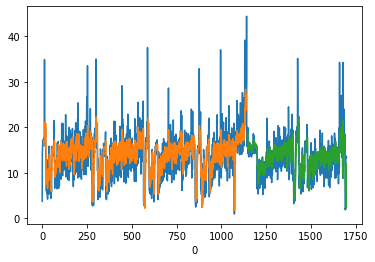

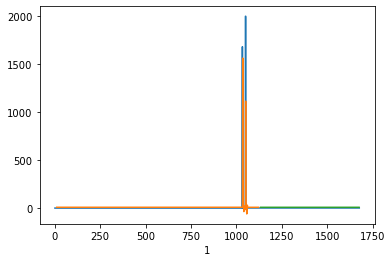

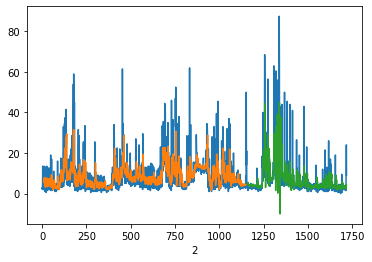

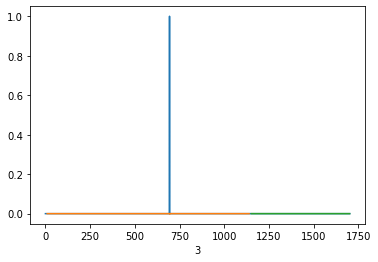

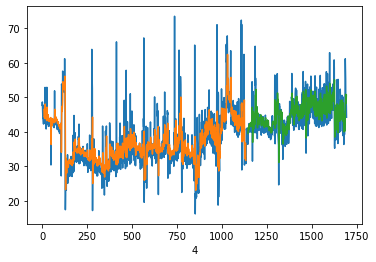

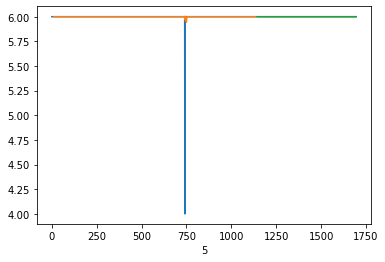

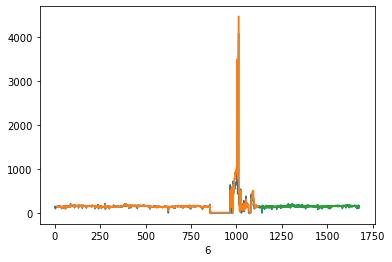

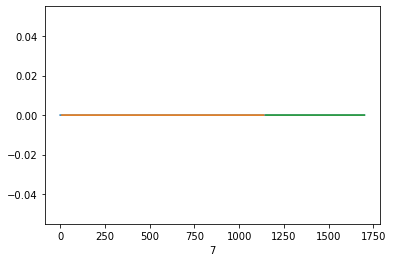

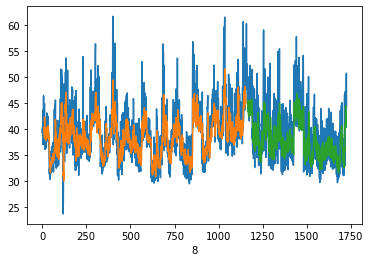

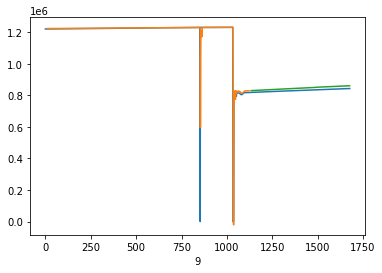

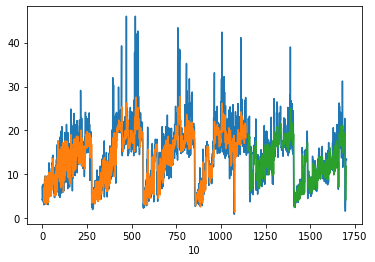

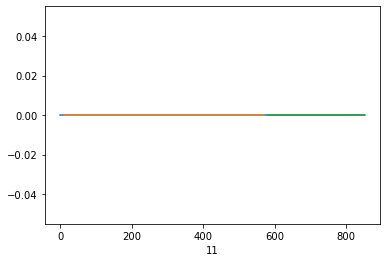

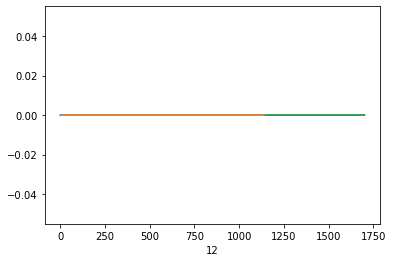

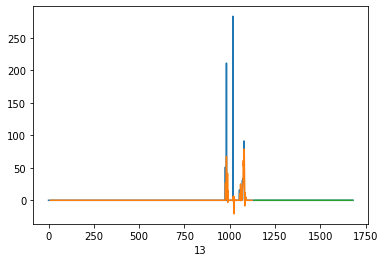

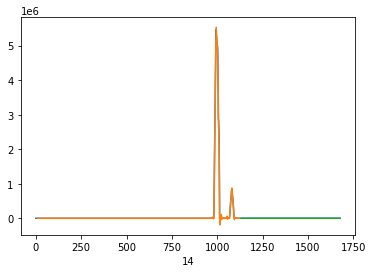

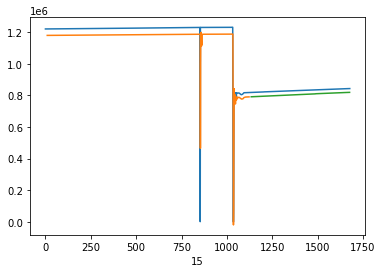

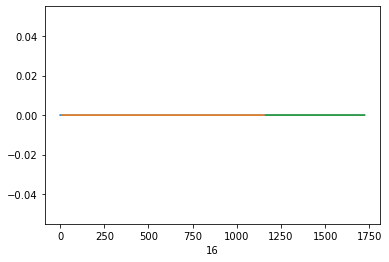

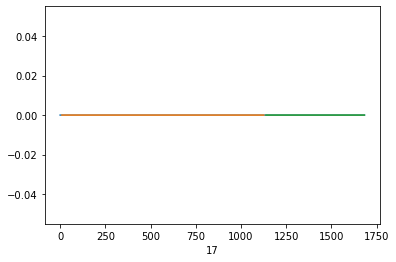

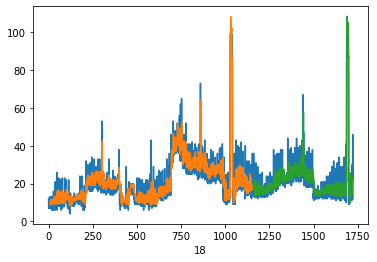

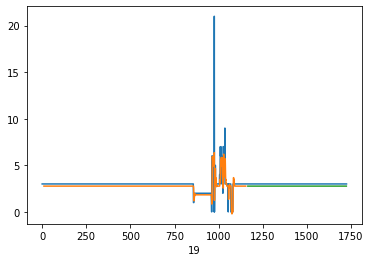

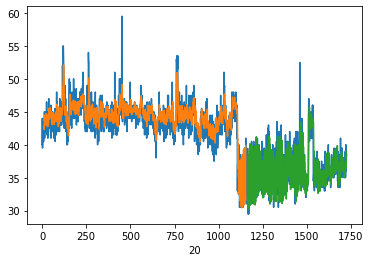

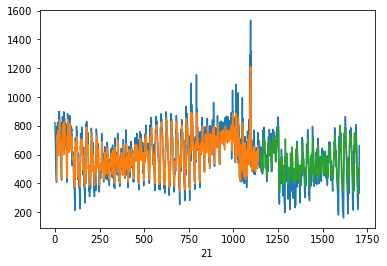

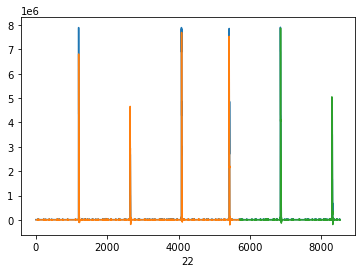

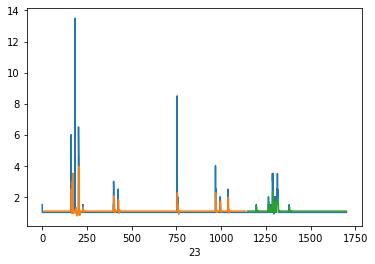

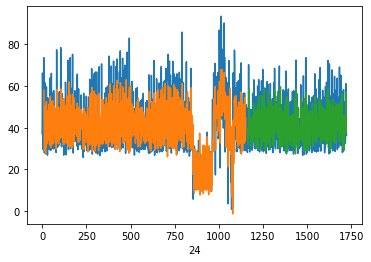

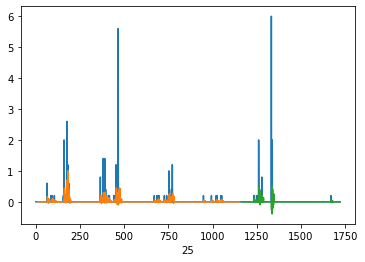

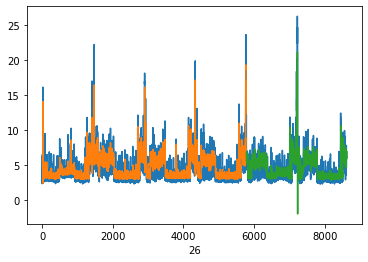

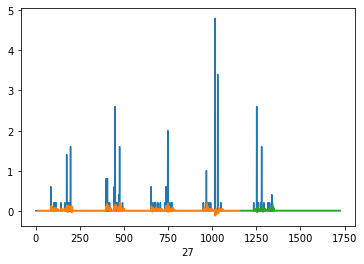

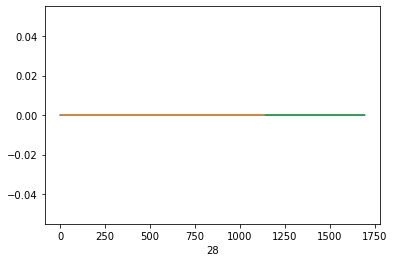

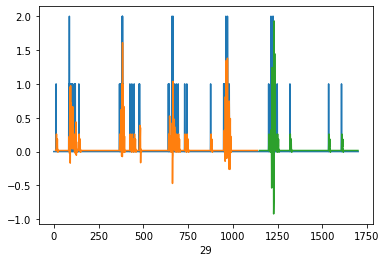

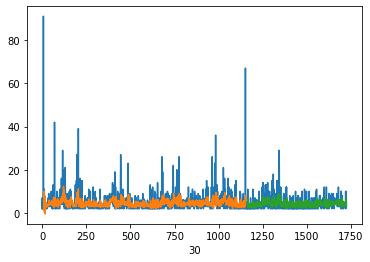

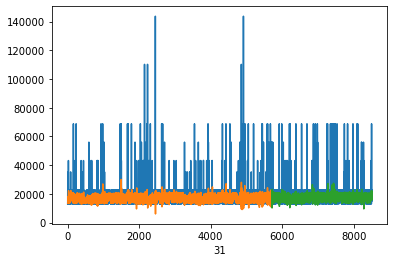

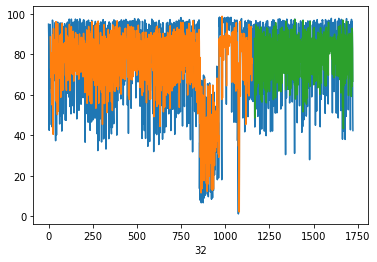

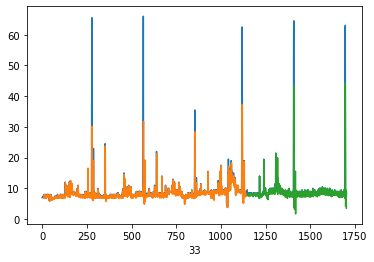

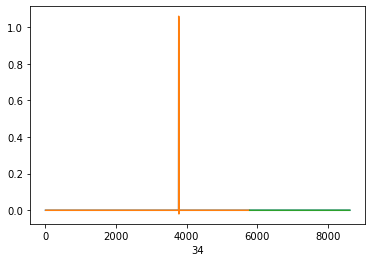

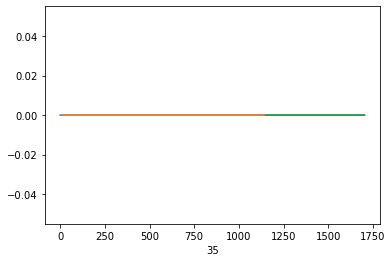

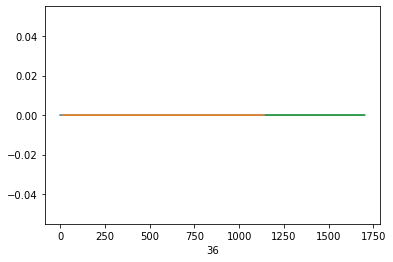

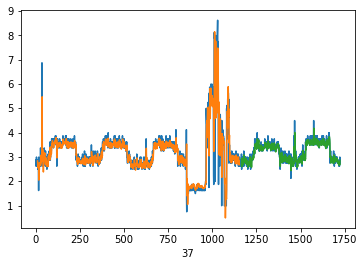

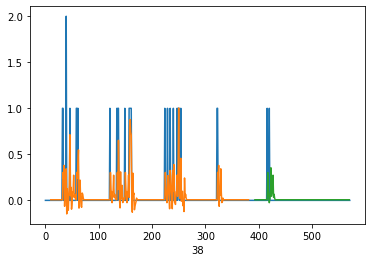

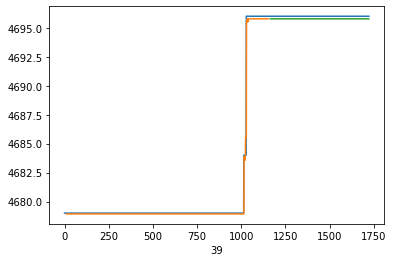

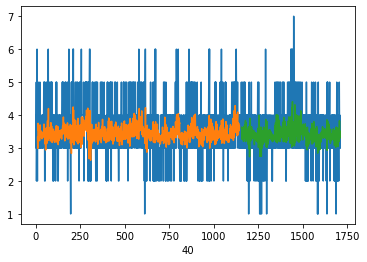

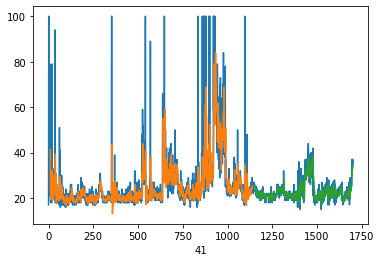

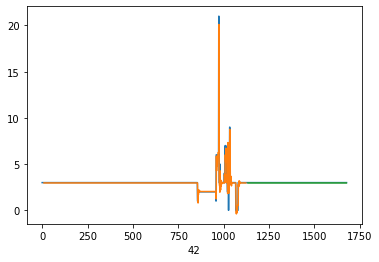

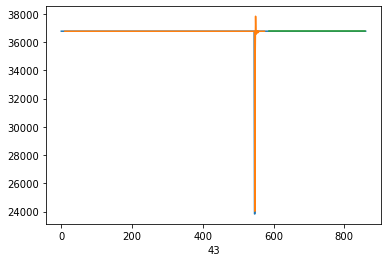

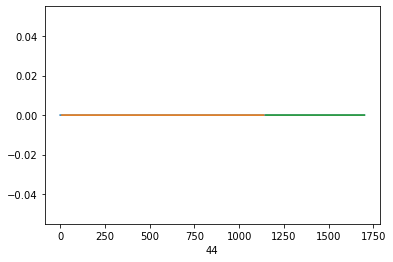

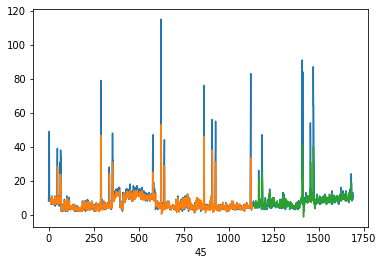

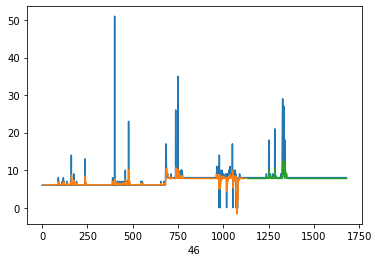

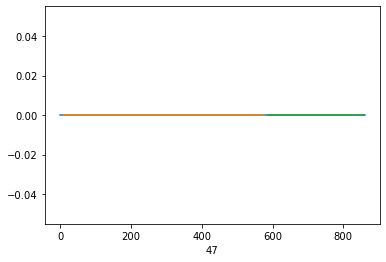

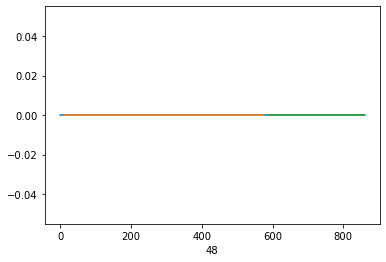

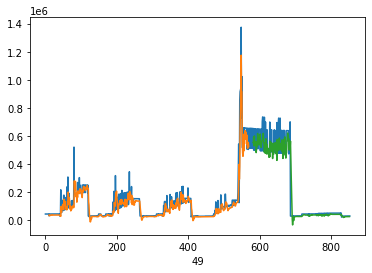

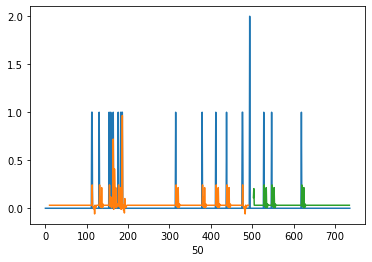

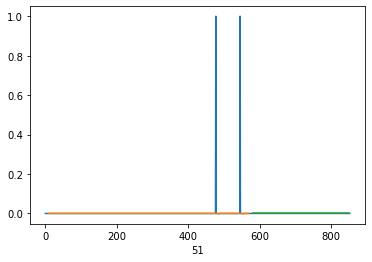

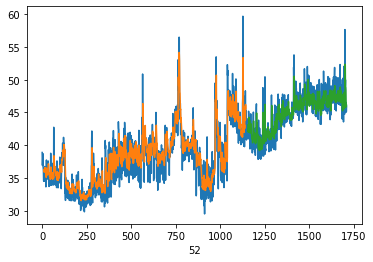

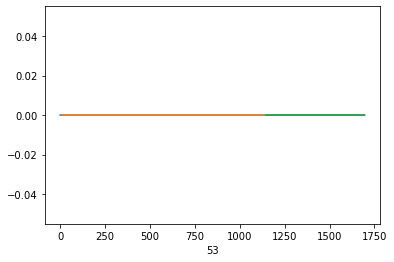

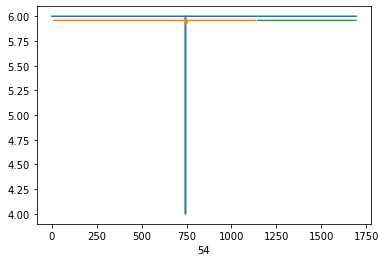

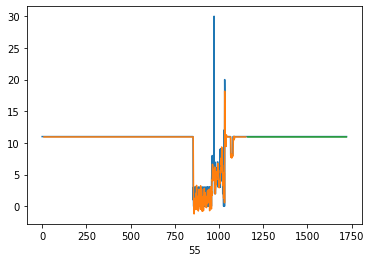

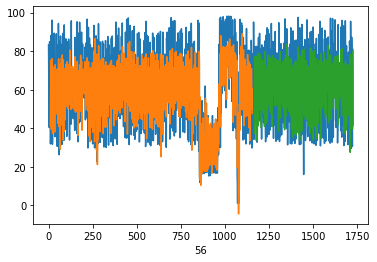

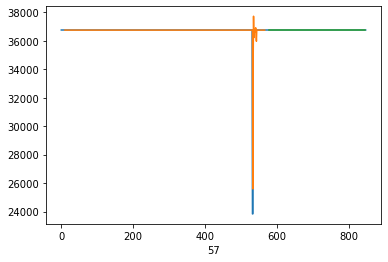

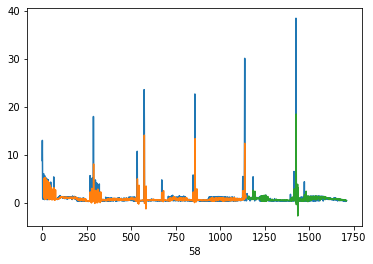

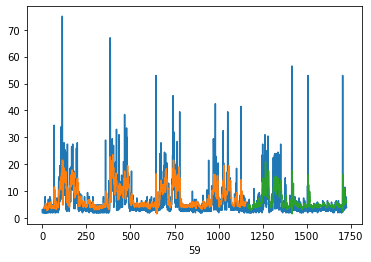

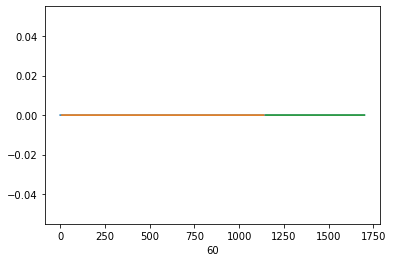

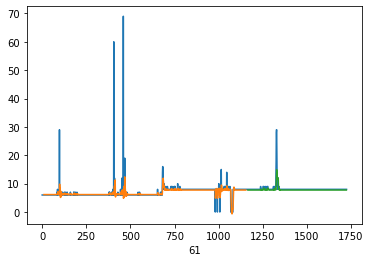

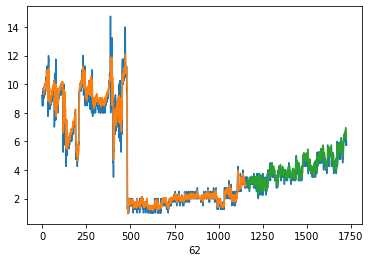

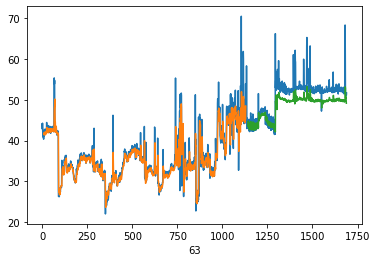

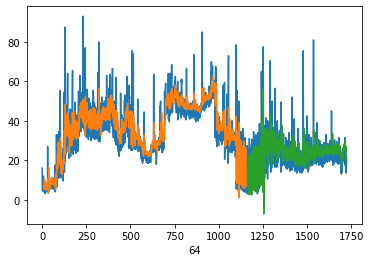

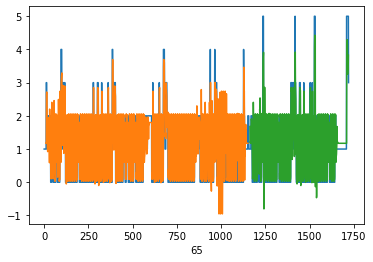

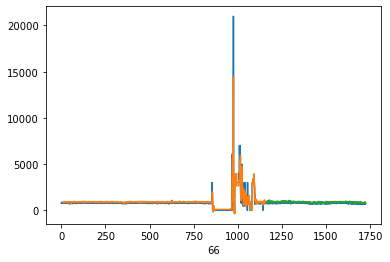

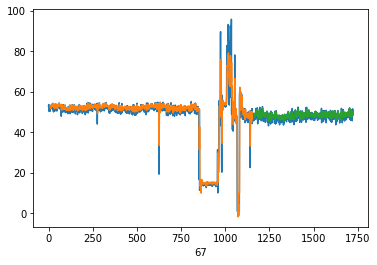

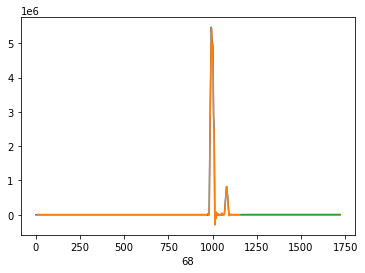

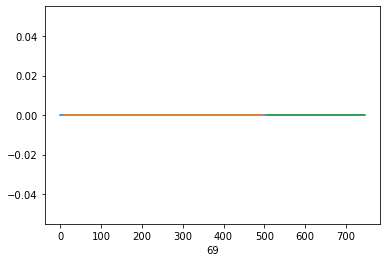

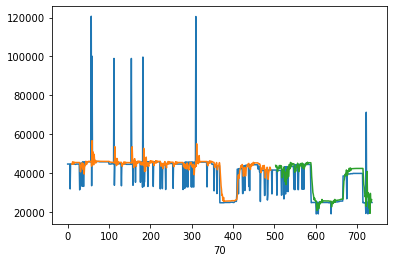

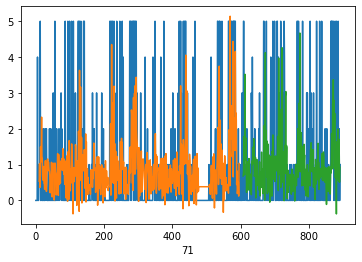

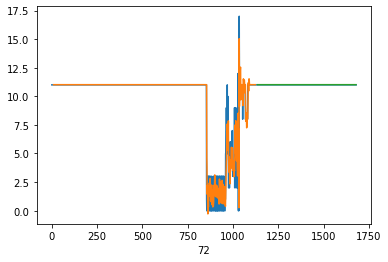

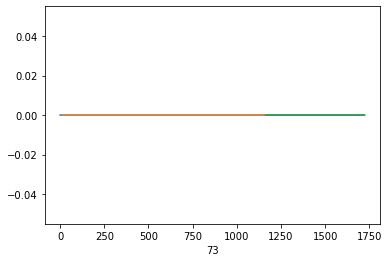

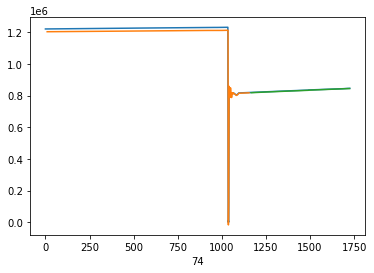

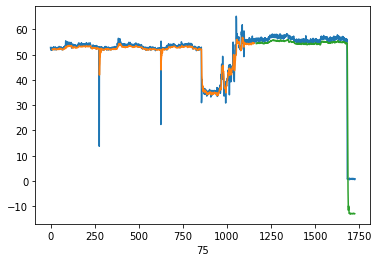

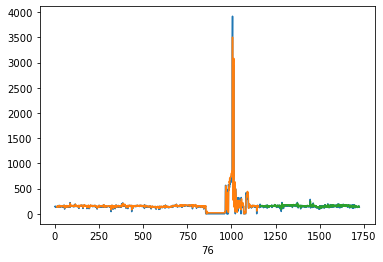

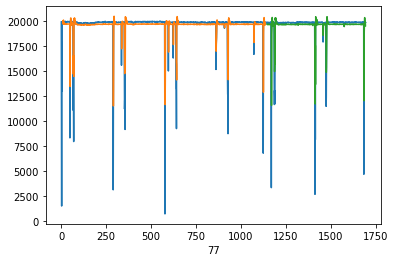

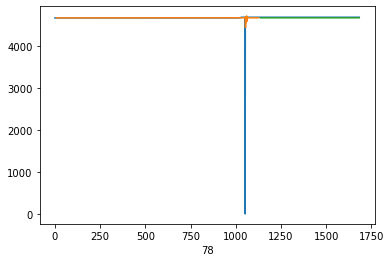

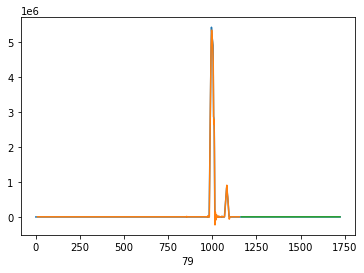

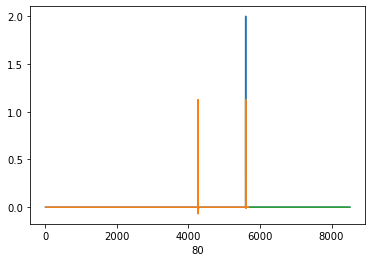

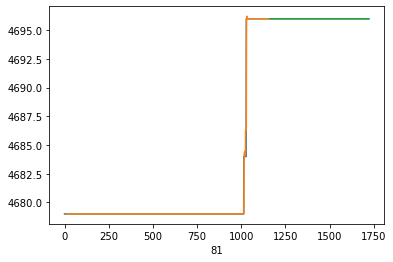

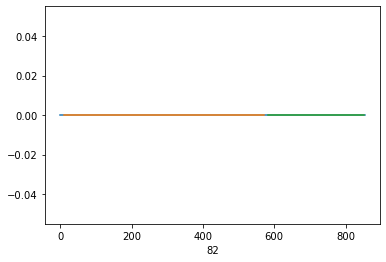

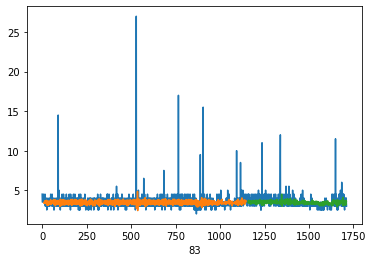

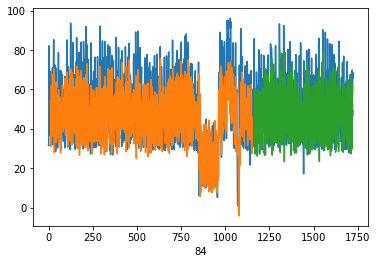

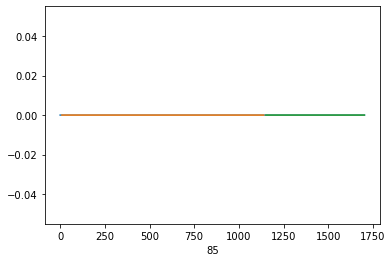

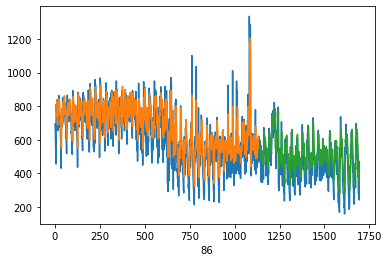

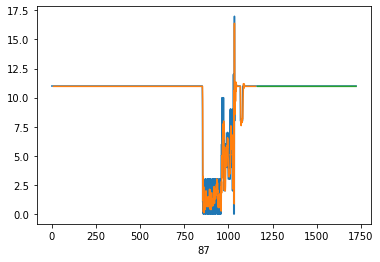

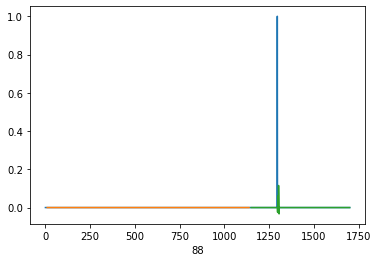

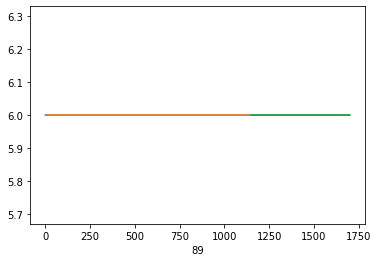

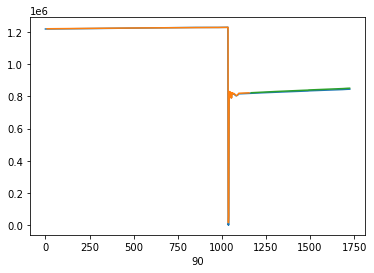

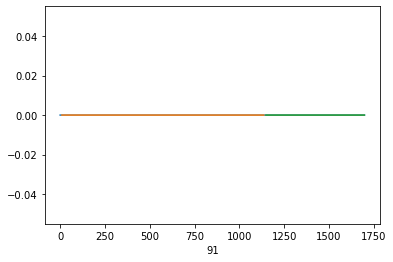

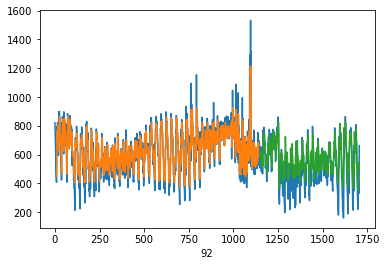

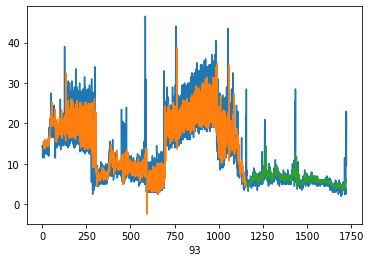

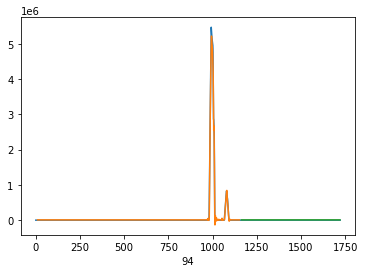

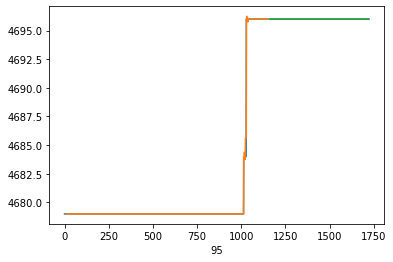

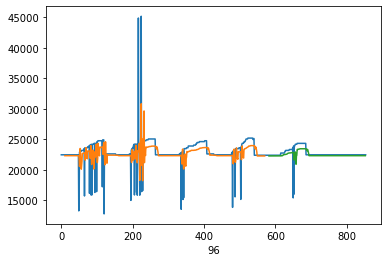

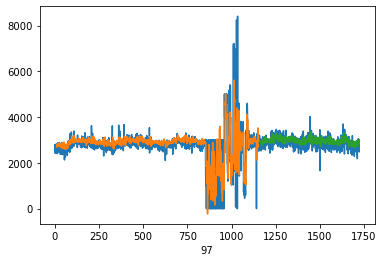

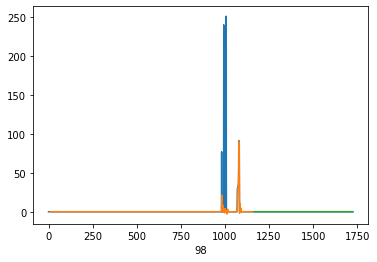

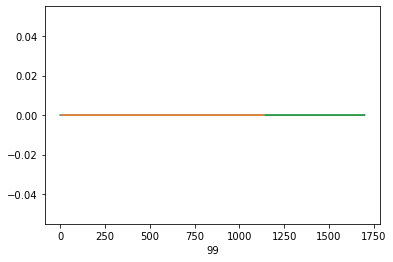

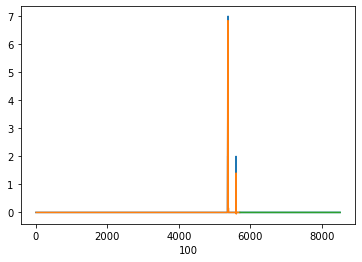

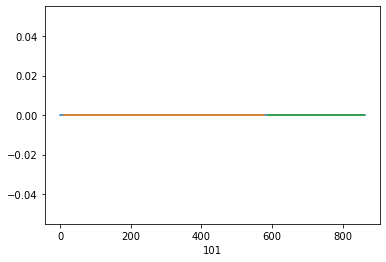

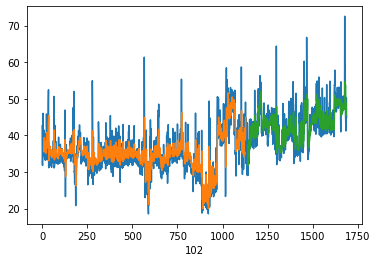

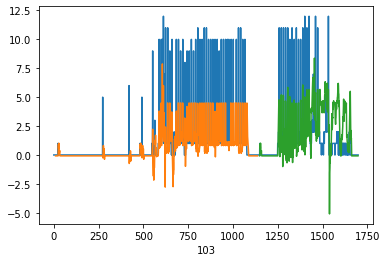

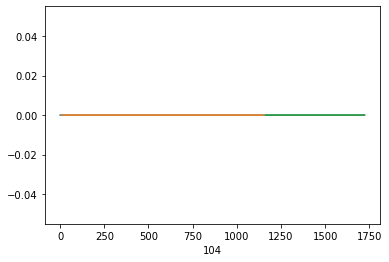

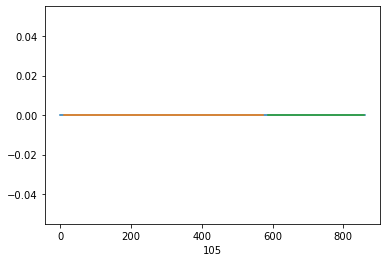

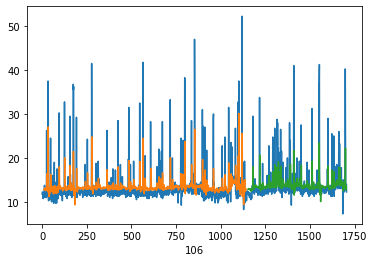

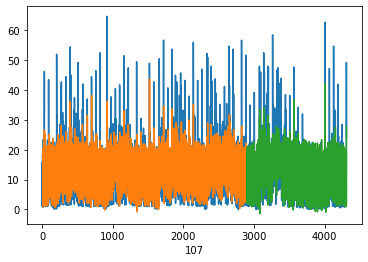

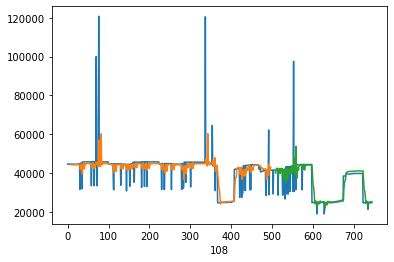

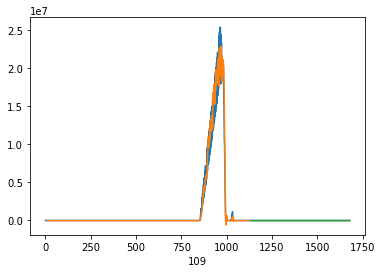

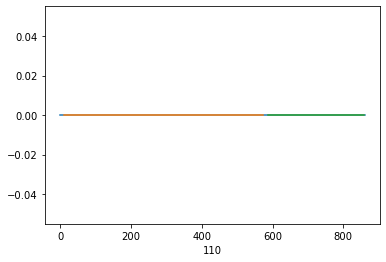

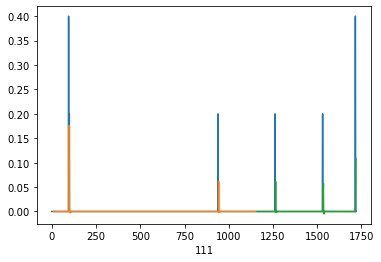

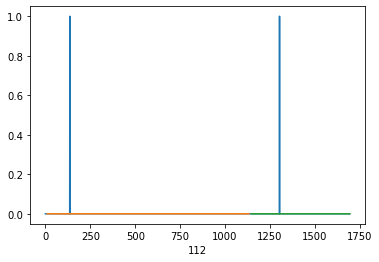

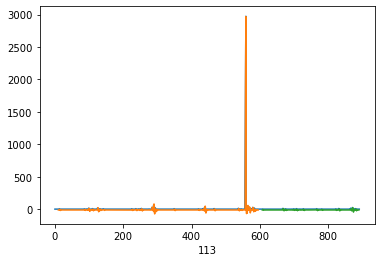

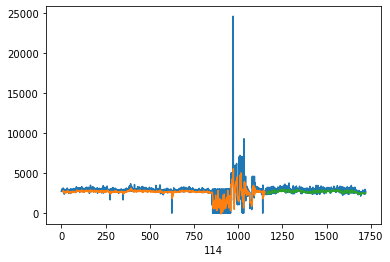

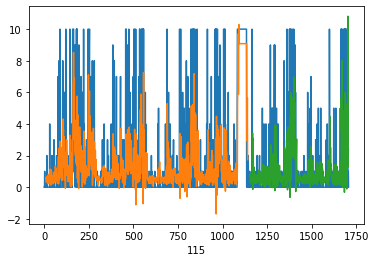

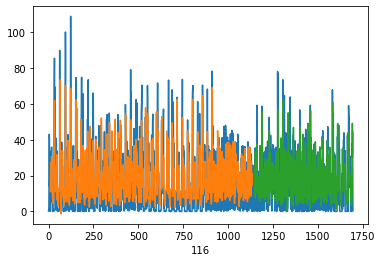

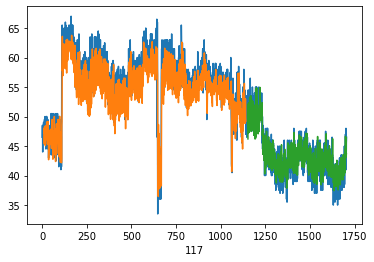

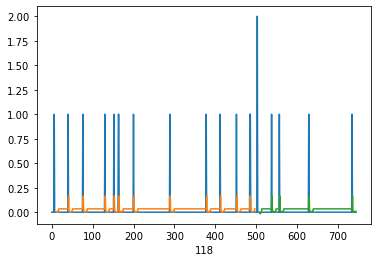

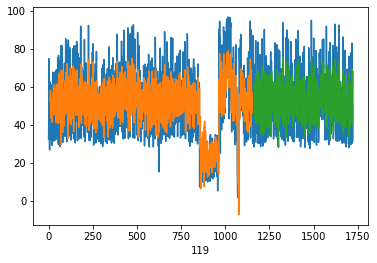

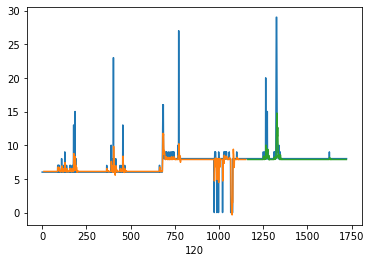

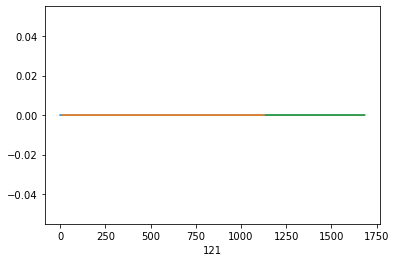

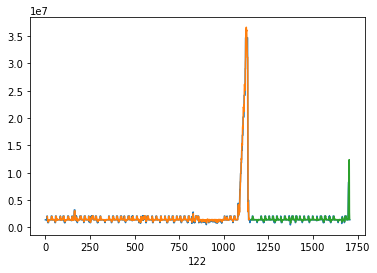

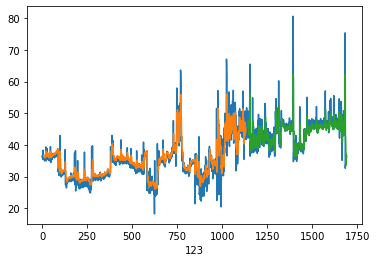

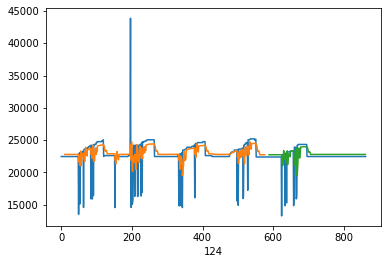

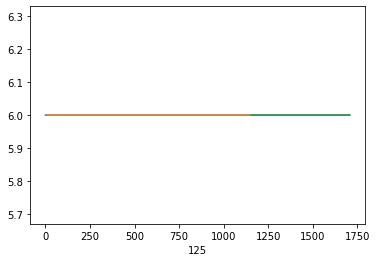

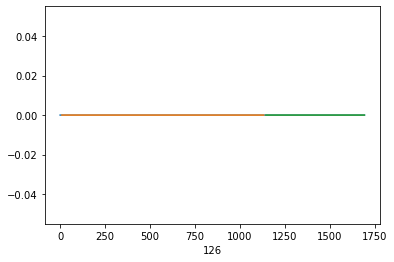

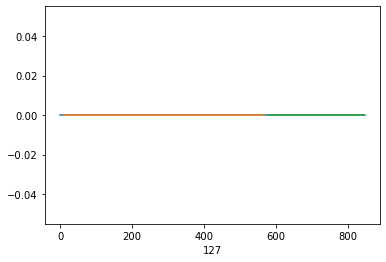

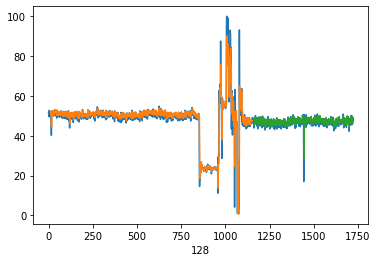

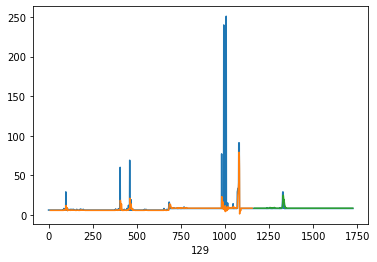

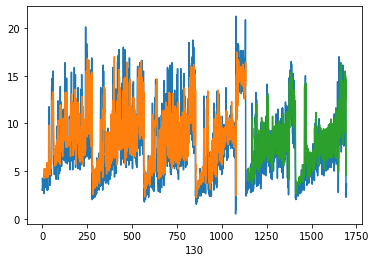

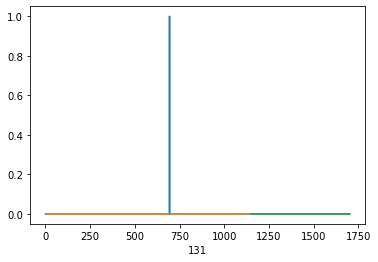

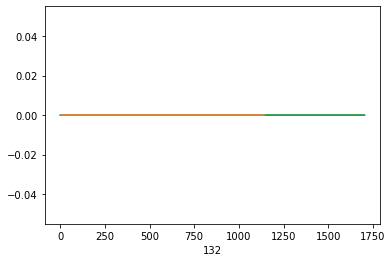

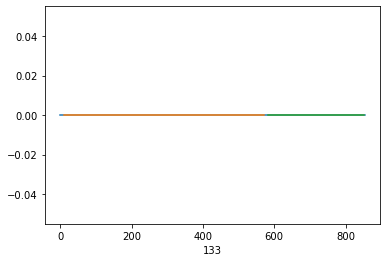

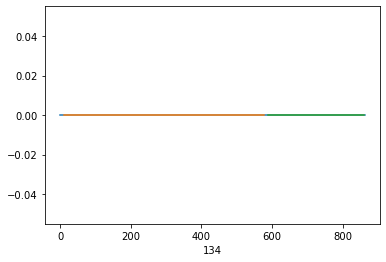

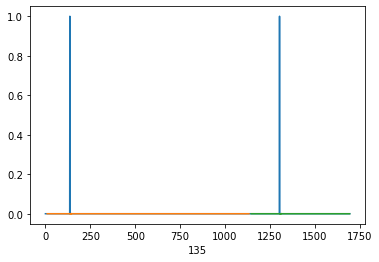

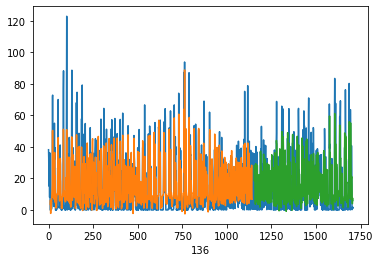

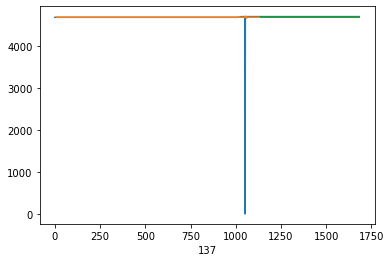

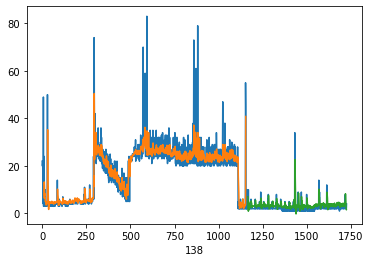

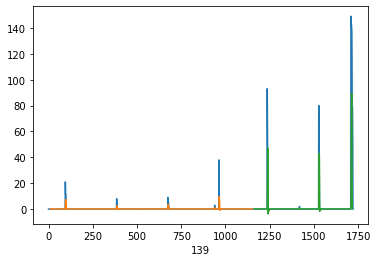

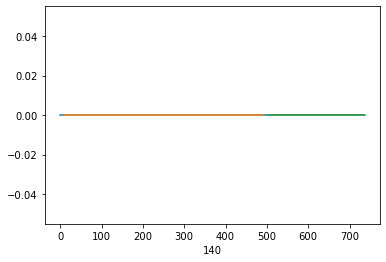

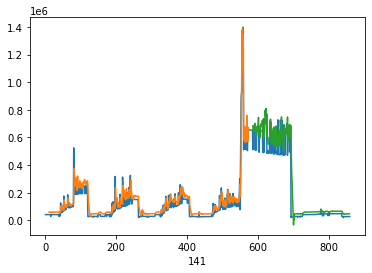

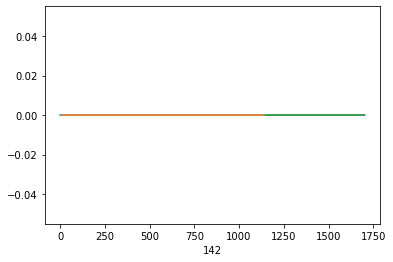

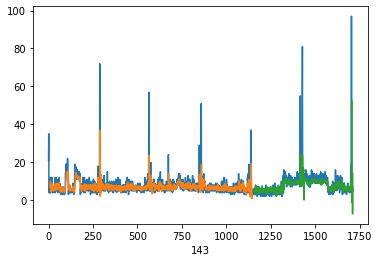

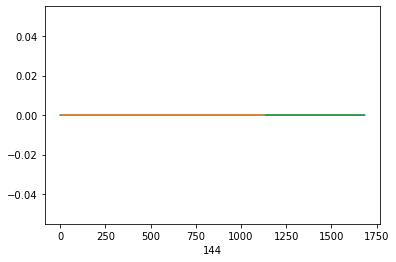

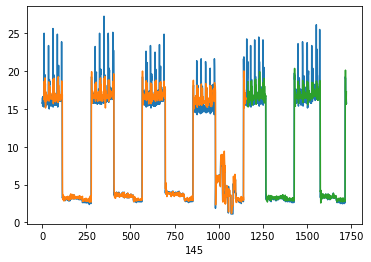

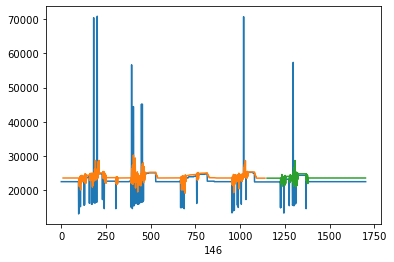

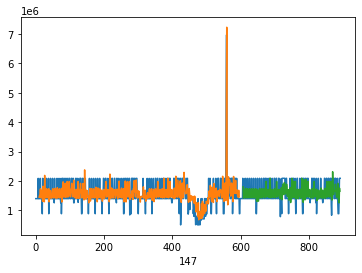

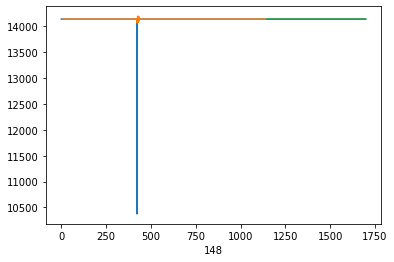

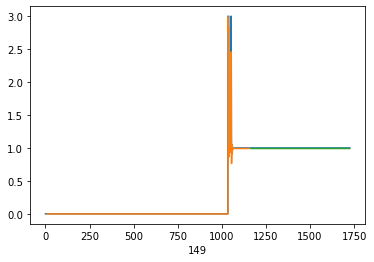

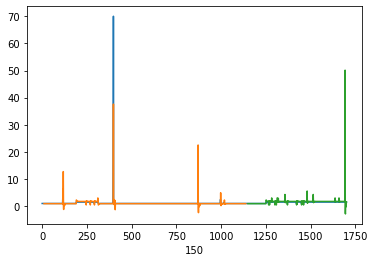

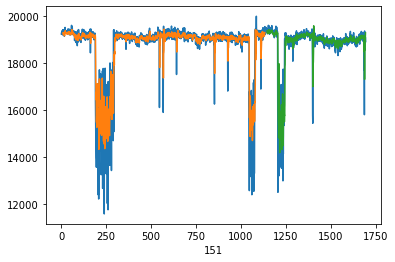

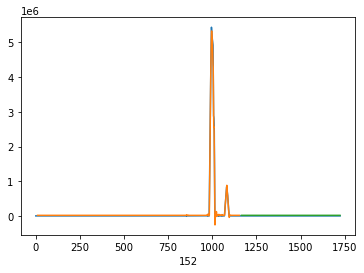

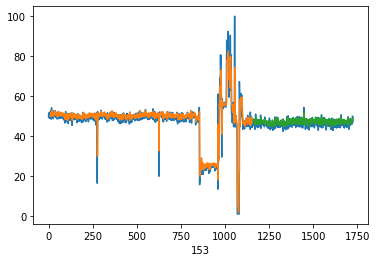

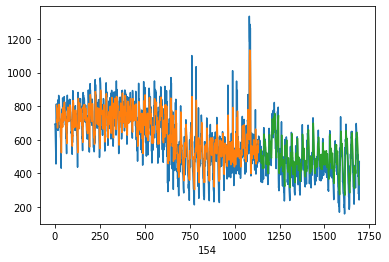

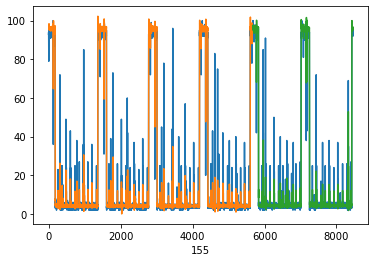

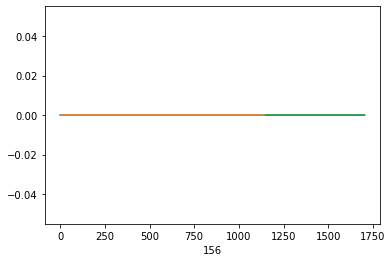

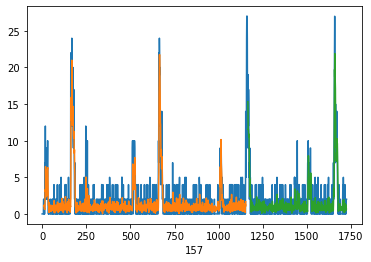

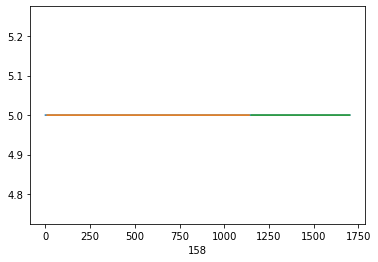

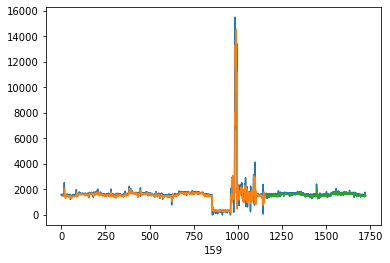

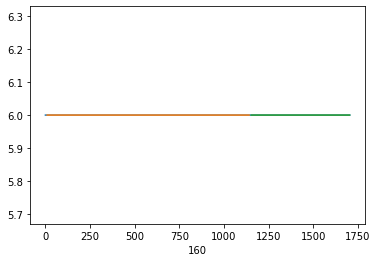

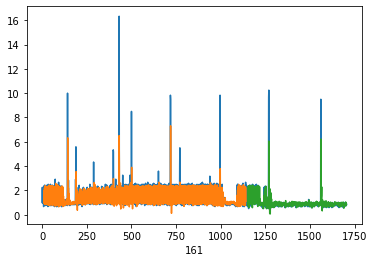

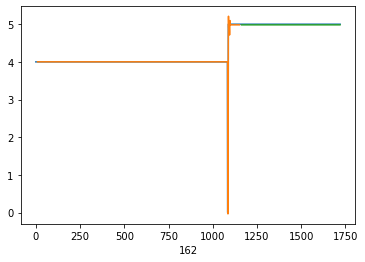

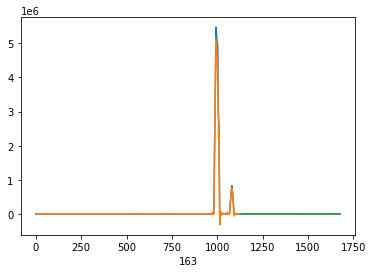

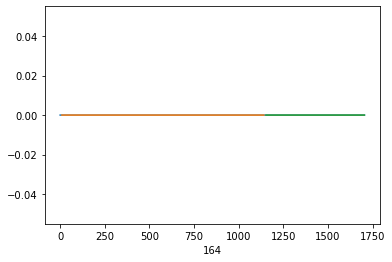

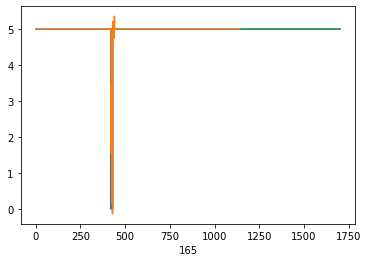

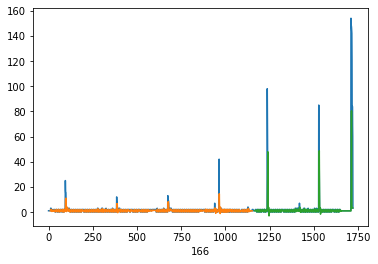

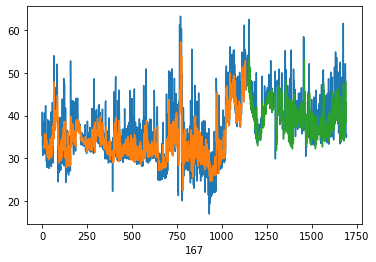

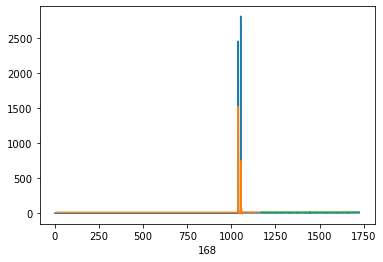

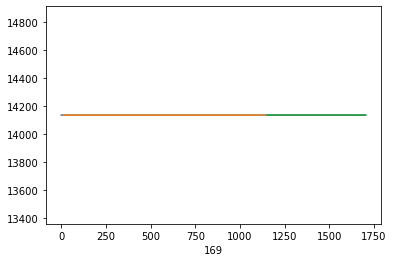

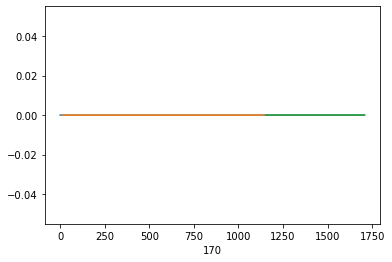

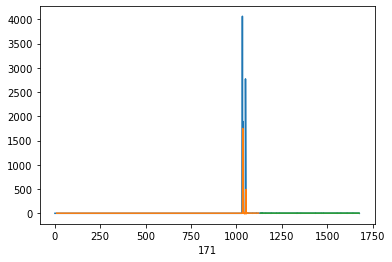

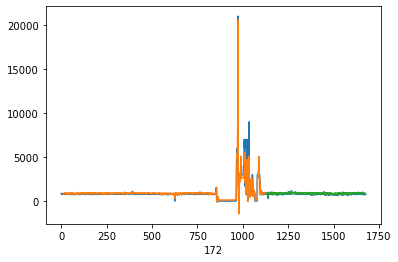

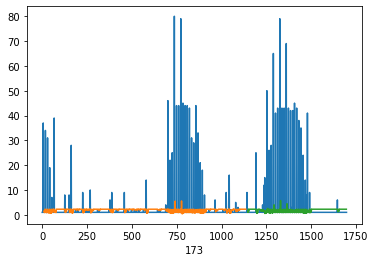

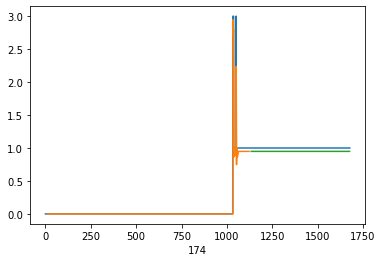

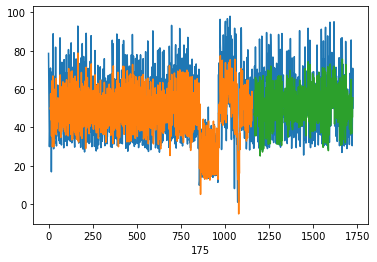

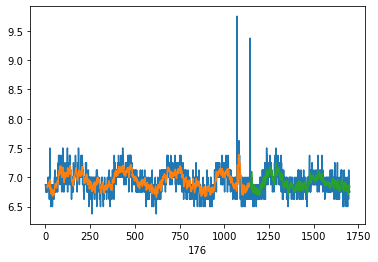

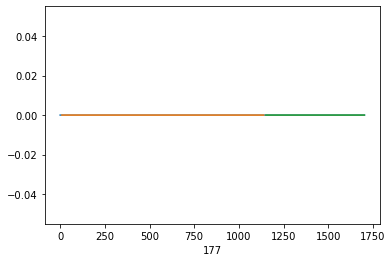

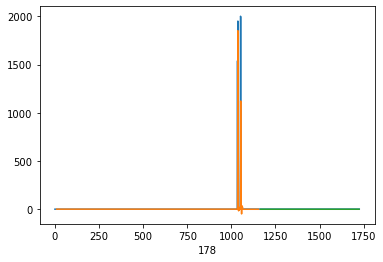

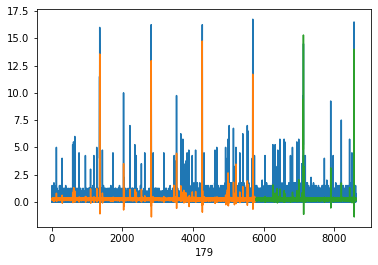

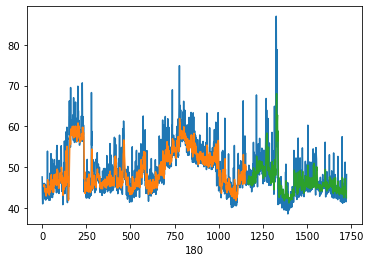

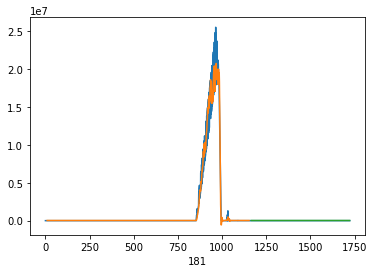

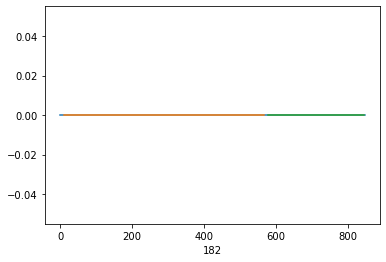

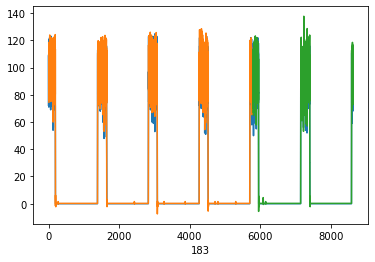

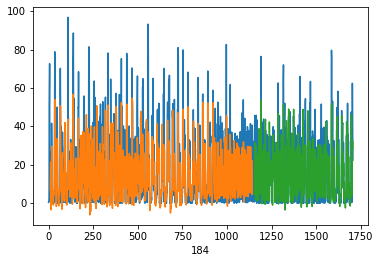

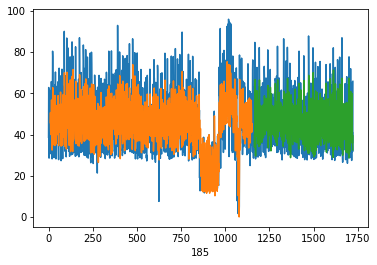

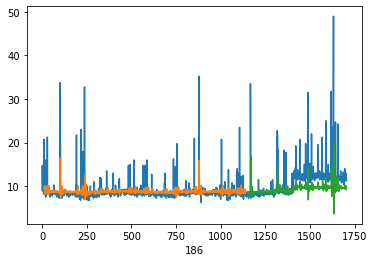

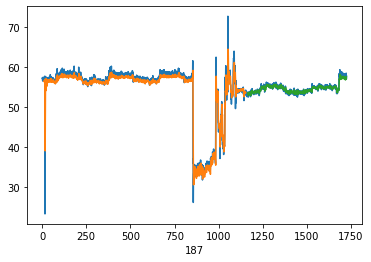

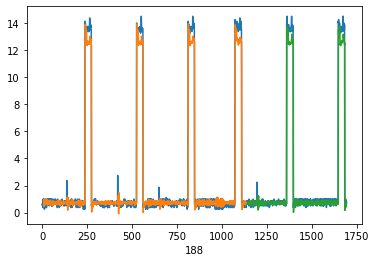

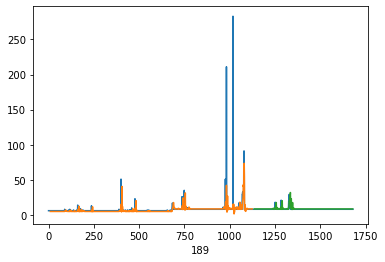

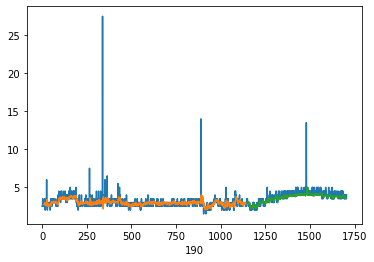

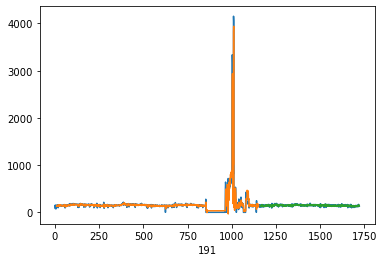

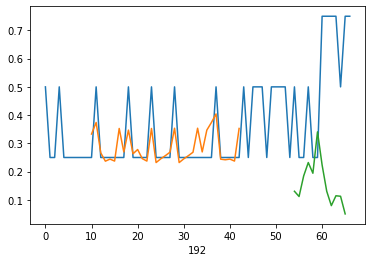

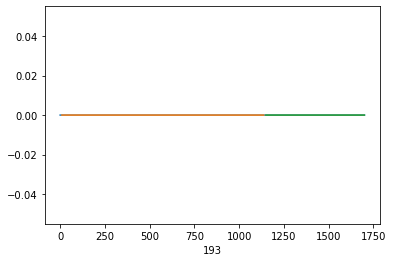

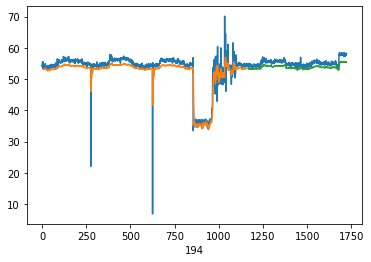

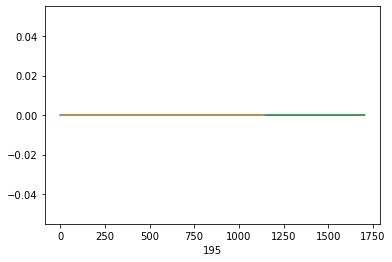

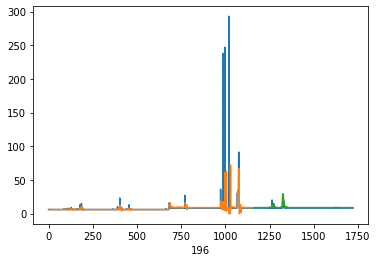

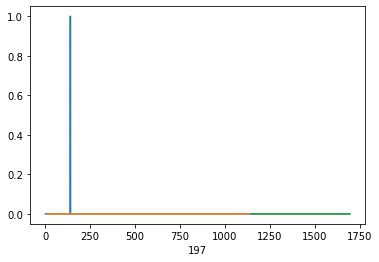

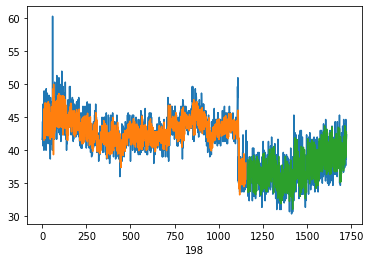

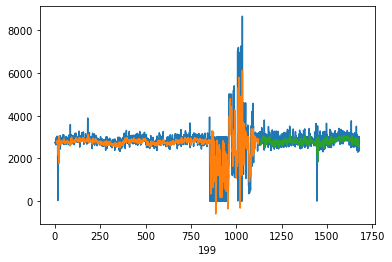

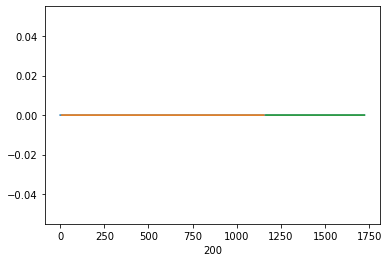

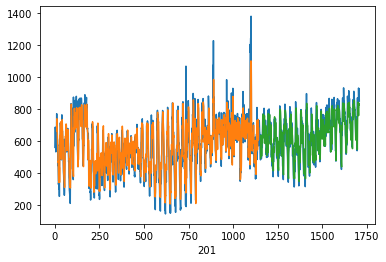

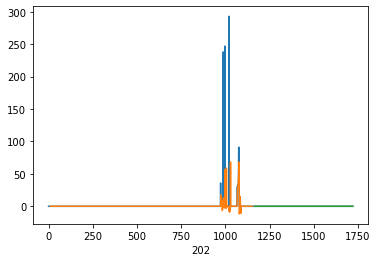

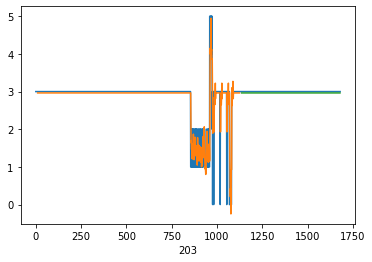

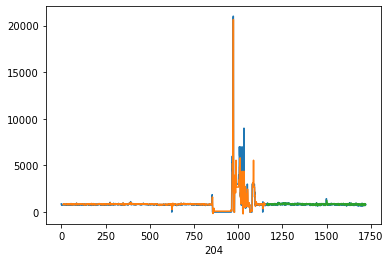

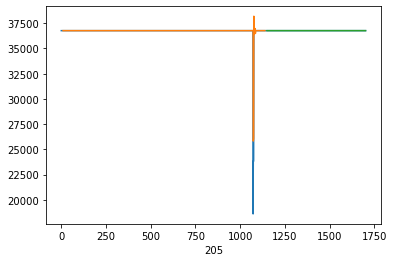

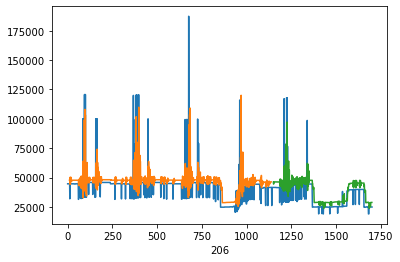

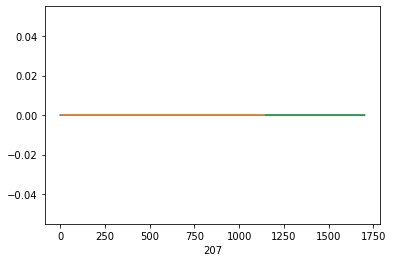

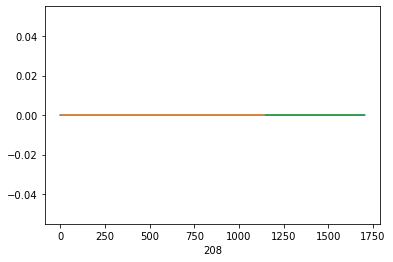

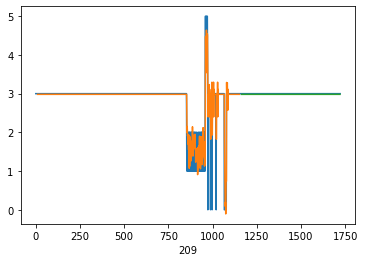

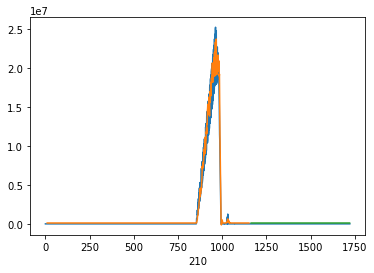

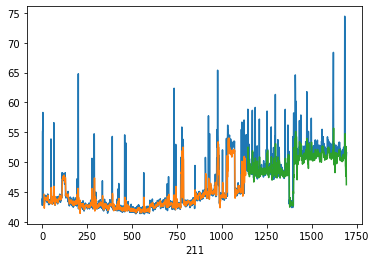

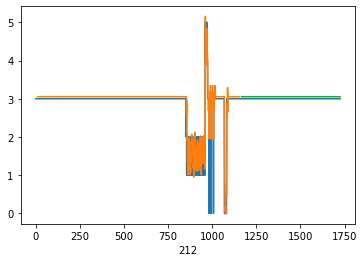

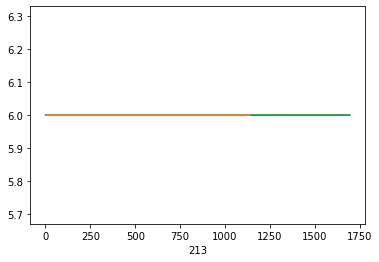

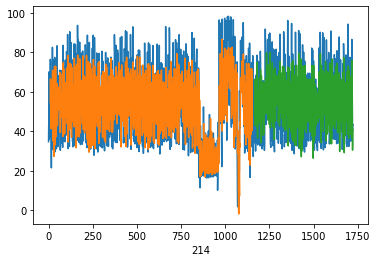

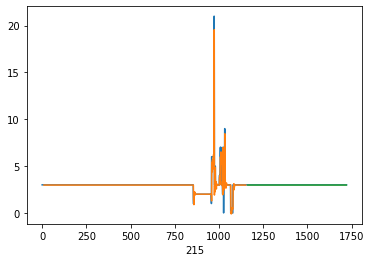

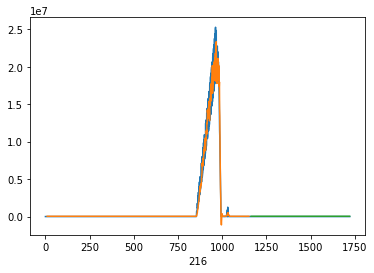

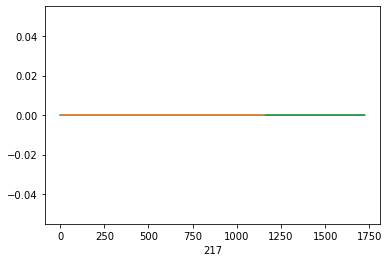

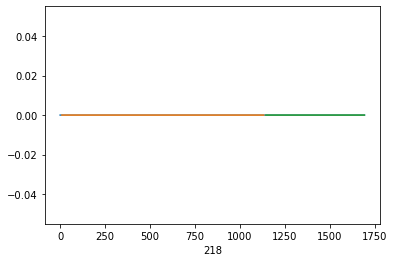

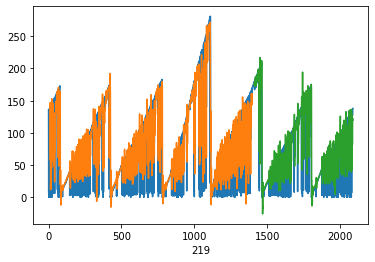

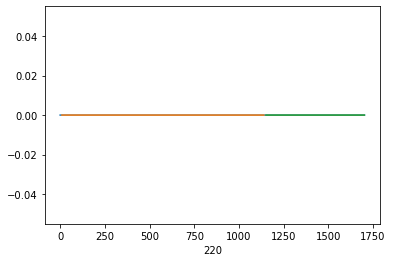

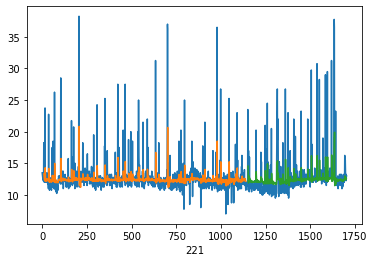

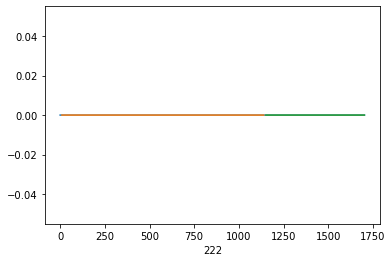

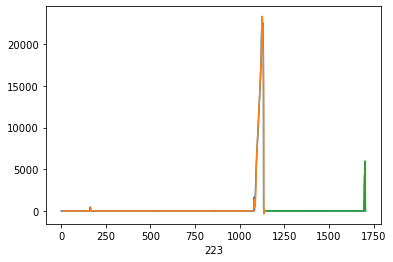

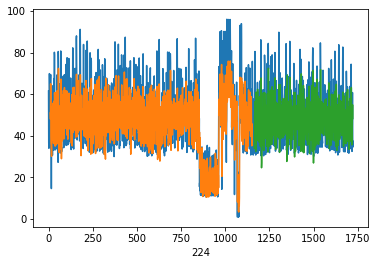

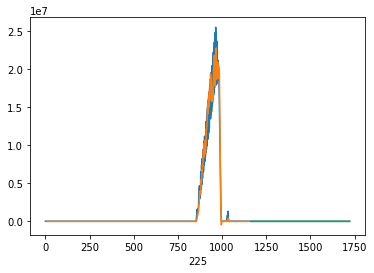

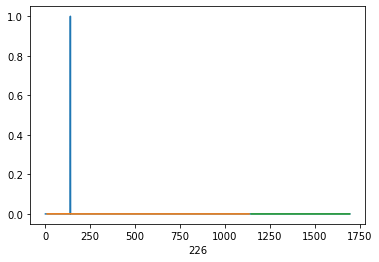

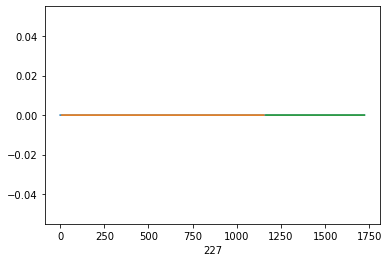

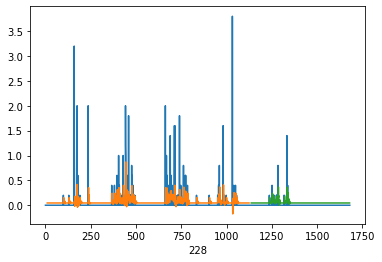

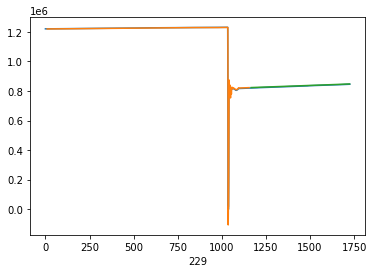

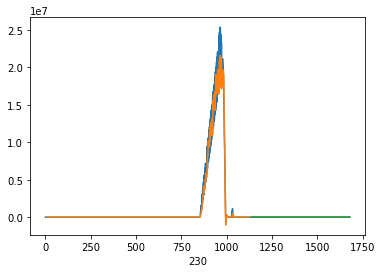

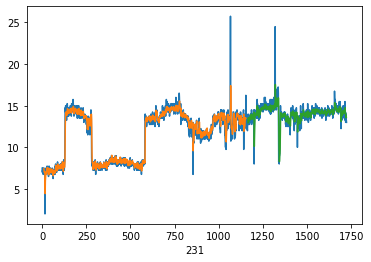

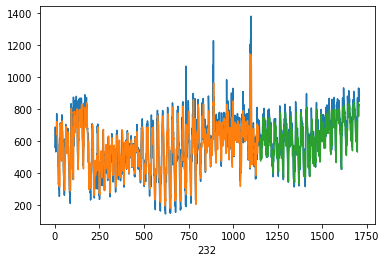

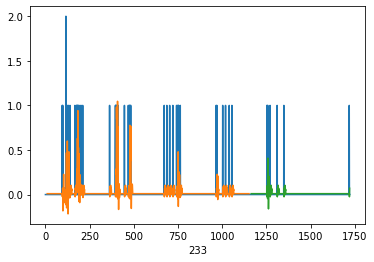

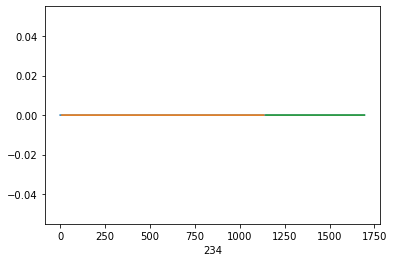

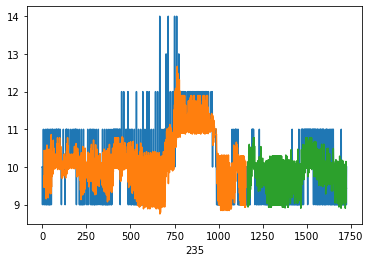

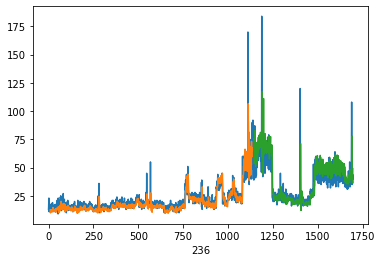

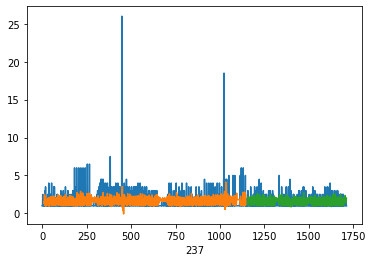

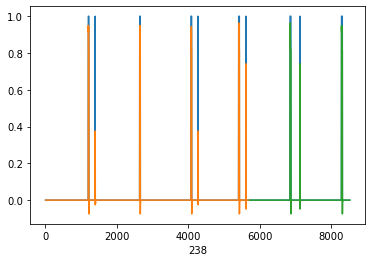

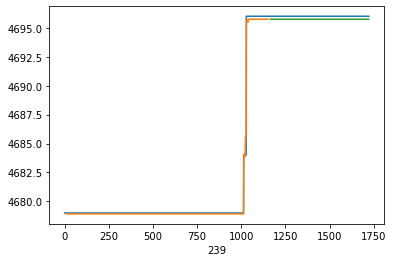

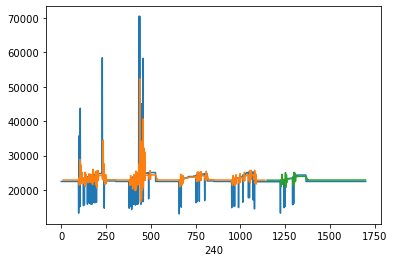

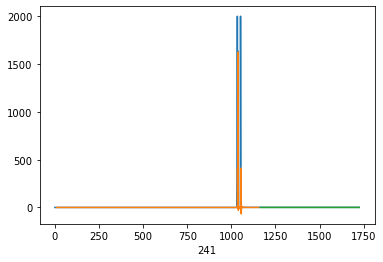

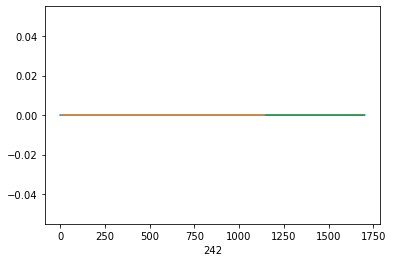

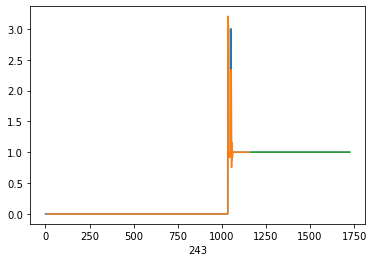

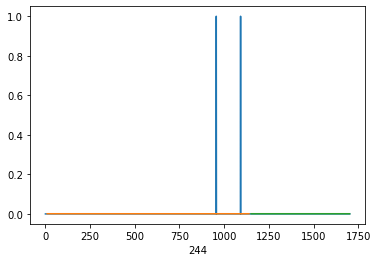

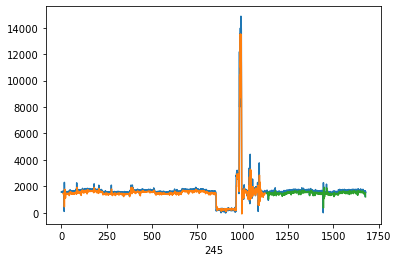

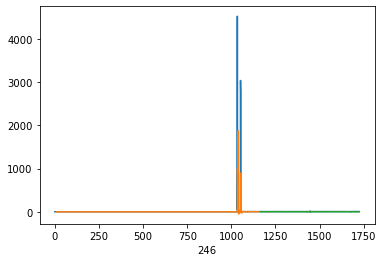

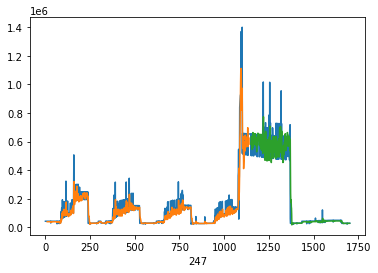

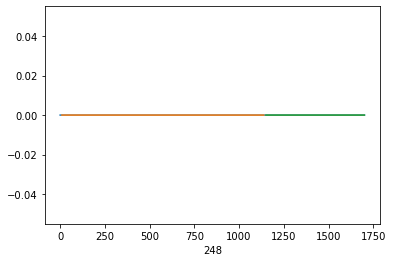

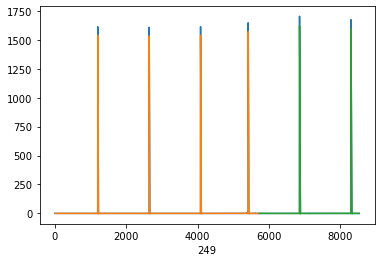

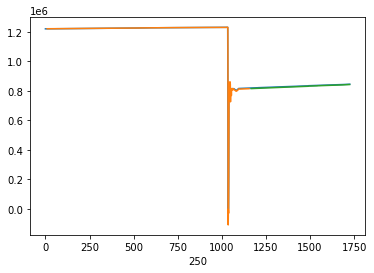

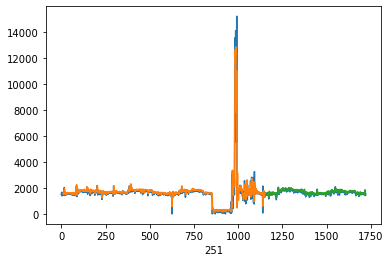

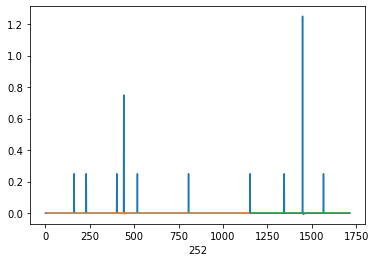

In [8]:
keys_id = list(dic_id.keys())
sample = len(keys_id)
for i in range(sample):
    indx = keys_id[i]
    fig, ax = plt.subplots()
    # shift train predictions for plotting
    trainPlot = np.empty_like(dic_id[indx][1].reshape(-1,1))
    trainPlot[:, :] = np.nan
    trainPlot[look_back:len(dic_id[indx][3][2])+look_back, :] = dic_id[indx][3][2]
    # shift test predictions for plotting
    validPlot = np.empty_like(dic_id[indx][1].reshape(-1,1))
    validPlot[:, :] = np.nan
    validPlot[len(dic_id[indx][3][2])+(look_back*2)+1:len(dic_id[indx][1])-1, :] = dic_id[indx][4][2]
    # plot baseline and predictions
    ax.set_xlabel(str(i))
    ax.plot(dic_id[indx][1].reshape(-1,1))
    ax.plot(trainPlot)
    ax.plot(validPlot)
plt.show()

In [9]:
l = []
for indx_name in keys_name:
    somme = 0
    cptr = 0
    for indx_id in dic_name[indx_name]:
        somme += dic_id[indx_id][2]
        cptr += 1
    l.append(somme/cptr)
    
dic = {'metric_name':keys_name, 'r2_mean':l}
mean_error = pd.DataFrame(dic)
print(mean_error)

                metric_name       r2_mean
0             cpu_prct_used      4.391394
1   messages_unacknowledged     34.116161
2                  messages   6676.624268
3                 cpu_usage      4.836221
4                 consumers      0.026214
5                       ack     23.304849
6            messages_ready   4669.432384
7            memoryConsumed  70772.932772
8                       cpu      1.094901
9                 cpu_ready      8.498416
10                 cpu_wait   1056.923054
